# Watershed delineation 
## with WhiteboxTools in R
WhiteboxTools offer a fast, convienient and reproducible way to delineate watersheds. The topographic data can be downloaded from the OpenTopography API with the elevatr package.   

In this example, the watershed of the Indrawati River at Melamchi in Nepal is delineated.

## Installation of WhiteboxTools

In [1]:
# Installation of WhiteboxTools
devtools::install_github("giswqs/whiteboxR")
whitebox::install_whitebox()
whitebox::wbt_init()
library(whitebox)

## Download  the DEM
Download a DEM from the Open Topography global datasets API using the elevar package.
The available DEMs are: SRTM 90m ("gl1"), SRTM 30m ("gl3"), SRTM 15+V2.1 ("srtm15plus"), AW3D 30m ("alos")

Loading required package: sp
Warning message:
"package 'sp' was built under R version 3.6.3"Loading required package: abind
Loading required package: sf
Warning message:
"package 'sf' was built under R version 3.6.3"Linking to GEOS 3.9.0, GDAL 3.2.1, PROJ 7.2.1
Warning message:
"package 'rgdal' was built under R version 3.6.3"rgdal: version: 1.5-23, (SVN revision 1121)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.2.1, released 2020/12/29
Path to GDAL shared files: D:/Programs/Anaconda/envs/R/Lib/R/library/rgdal/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 7.2.1, January 1st, 2021, [PJ_VERSION: 721]
Path to PROJ shared files: D:/Programs/Anaconda/envs/R/Lib/R/library/rgdal/proj
PROJ CDN enabled: FALSE
Linking to sp version:1.4-5
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.
Overwritten PROJ_LIB was D:/Programs/Anac

Downloading: 4.1 MB       


Mosaicing & Projecting
Clipping DEM to locations
Note: Elevation units are in meters.
Warning message in .gd_SetProject(object, ...):
"NOT UPDATED FOR PROJ >= 6"

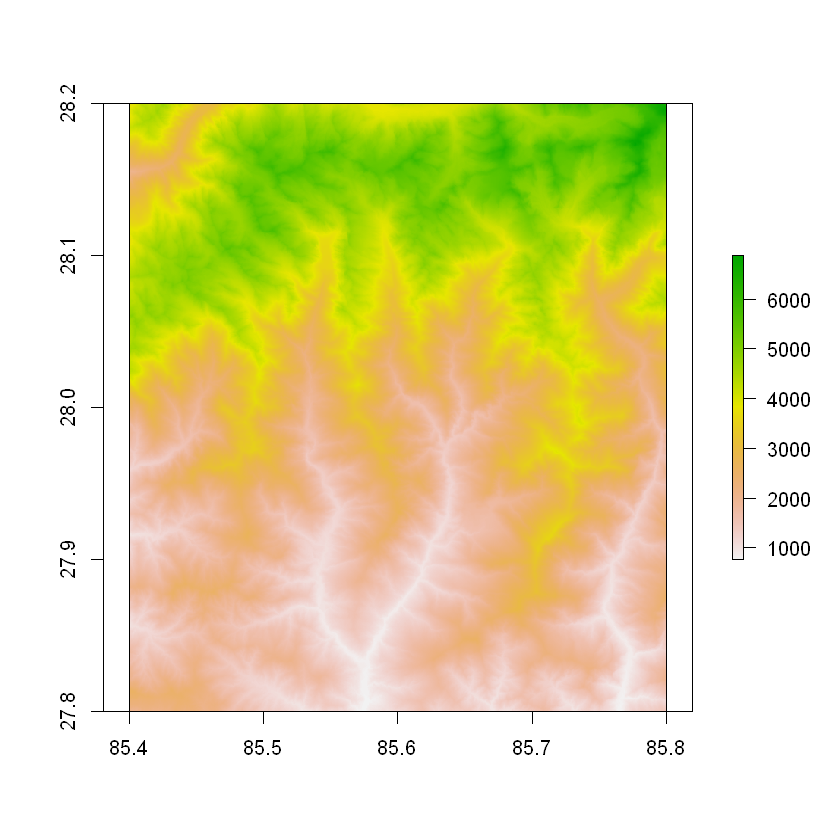

In [2]:
library(raster)
library(sp)
library(stars)
library(rgdal)
library(elevatr)

# Path of the output files
path <- "F:/dem/"

# Define corners of the study area
x_min <- 85.4
x_max <- 85.8
y_min <- 27.8
y_max <- 28.2

# Alternatively load a shapefile of the AOI
#bb <- readOGR(dsn = "F:/DopeData/dem/","AOI")

# Create polygon of the AOI
cords <- data.frame("x" = c(x_min, x_max, x_max, x_min), "y" = c(y_min, y_min, y_max, y_max)) 
bb = Polygon(cords)
bb = Polygons(list(bb),1)
bb = SpatialPolygons(list(bb))

# Define coordinate system of the bounding box
crs(bb) <- CRS("+init=EPSG:4326")

# Load the DEM
dem <- get_elev_raster(bb, src = "alos", clip = "locations") 
# For large areas (>3GB) set flag: override_size_check = TRUE

plot(dem)
plot(bb, add = TRUE)

# Save it locally
filename <- paste(path, "dem.tif", sep = "")
writeRaster(dem, filename, overwrite = TRUE)

## Derivation of the stream network
This step comprises the filling of the sinks in the DEM, the generation of the flow direction, flow accumulation raster and the stream network.

In [3]:
# Fill sinks
wbt_fill_single_cell_pits(
    dem = paste(path, "dem.tif", sep = ""),
    output = paste(path, "dem_tmp.tif", sep = ""))
wbt_breach_depressions(
    dem = paste(path, "dem_tmp.tif", sep = ""),
    output = paste(path, "dem_fill.tif", sep = ""),
  fill = TRUE)

# Flow direction
wbt_d8_pointer(
    dem = paste(path, "dem_fill.tif", sep = ""),
    output = paste(path, "fldir.tif", sep = ""))

# Flow accumulation
wbt_d8_flow_accumulation(
    input = paste(path, "dem_fill.tif", sep = ""),
    output = paste(path, "facc.tif", sep = ""))

## Derive stream network (threshold defines the mimimum number of upstream cells required for a stream)
wbt_extract_streams(
    flow_accum =  paste(path, "facc.tif", sep = ""),
    output =  paste(path, "streams.tif", sep = ""),
    threshold = 2000)


## Create the outlet
The outlet defines the downstream border of the catchment. First we create a point with the rough estimation of the catchment outlet and snap it to the stream. 

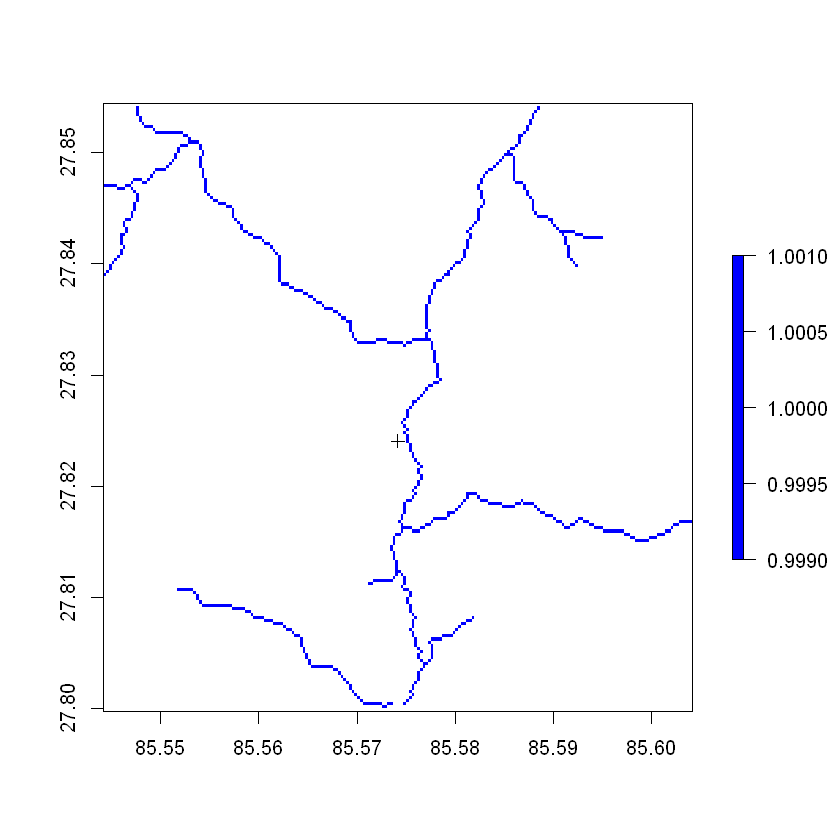

In [4]:
# Create shapefile of the catchment outlet 
coords <- data.frame("x" = 85.574149, "y" = 27.824044)
outlet <- SpatialPoints(coords, proj4string = CRS("+init=EPSG:4326"))
shapefile(outlet, filename = paste(path, "outlet.shp", sep = ""), overwrite = TRUE)

# Load streams
streams <- raster(paste(path, "streams.tif", sep = ""))

# Plot it
plot(streams, col = "blue",  xlim = c(coords$x - 0.03,coords$x + 0.03), ylim = c(coords$y - 0.03, coords$y + 0.03))
plot(outlet,  add = TRUE,  pch = 3)

Now the outlet needs to be snapped to the stream network. In this case, the distance between outlet and stream is ~10 times the grid resolution.

Reading layer `outlet_snap' from data source `F:\DopeData\dem\outlet_snap.shp' using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 1 field
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 85.57514 ymin: 27.82403 xmax: 85.57514 ymax: 27.82403
Geodetic CRS:  WGS 84


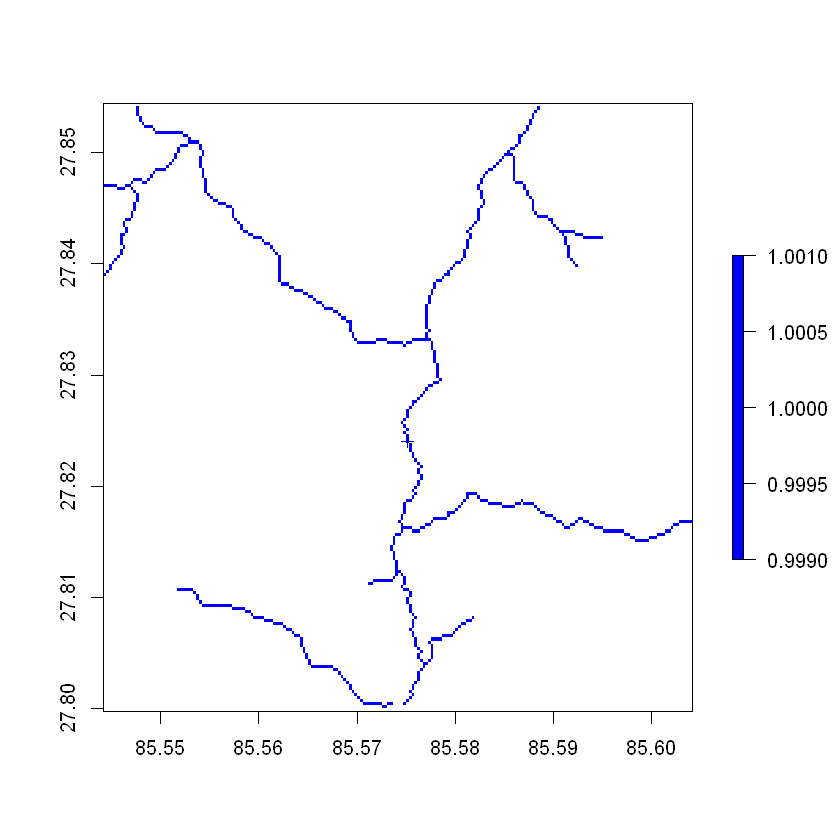

In [5]:
# Define snapping distance
dist <- 10
dist <- dist * xres(streams)

# Snap to raster
wbt_jenson_snap_pour_points(pour_pts = paste(path, "outlet.shp", sep = ""),
                            streams = paste(path, "streams.tif", sep = ""),
                            output = paste(path, "outlet_snap.shp", sep = ""),
                            snap_dist = dist) 

# check the outlet is snapped
outlet_snap <- st_read(paste(path, "outlet_snap.shp", sep = ""))
plot(streams, col = "blue",  xlim = c(coords$x - 0.03,coords$x + 0.03), ylim = c(coords$y - 0.03, coords$y + 0.03))
plot(outlet_snap,  add = TRUE, pch = 3)

## Delineate the watershed

Writing layer `watershed' to data source `F:/DopeData/dem/watershed.shp' using driver `ESRI Shapefile'
Writing 1 features with 1 fields and geometry type Polygon.


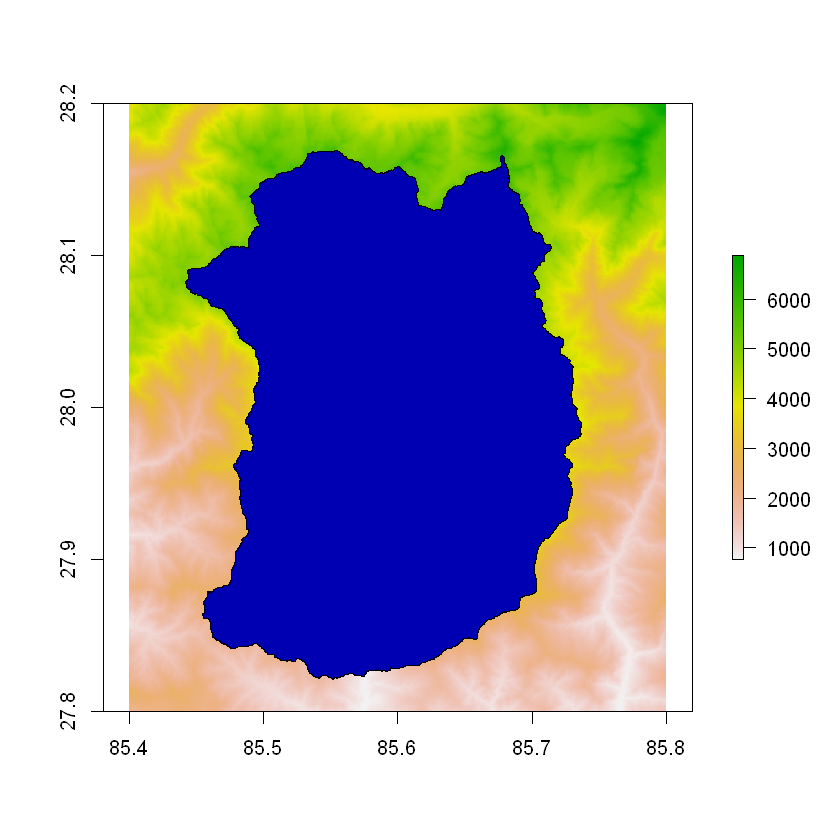

In [6]:
# Delineate watersheds
wbt_watershed(d8_pntr =  paste(path, "fldir.tif", sep = ""),
              pour_pts = paste(path, "outlet_snap.shp", sep = ""),
              output = paste(path, "watershed.tif", sep = ""))

# Convert watershed raster to polygon
ws <- raster(paste(path, "watershed.tif", sep = ""))
ws <- st_as_stars(ws)
ws <- st_as_sf(ws, merge = T)
st_write(ws, paste(path, "watershed.shp", sep = "")) # to overwrite previous file: delete_dsn = TRUE

# Plot it
plot(dem)
plot(ws, add = TRUE)